# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.7/214.7 kB 25.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=b88d41bf3f6df74c7f8be72fa4dfa815b1f0ed518986f1e22ccaea92151b0003
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import wandb

#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [ ]:
# Use CIFAR10 as dataset
# CIFAR10 transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


# Load CIFAR10 train and test
ds_train = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
ds_test = CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split train into train and validation.
val_size = 3000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 47758210.17it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
# Slight modification to the previous training and evaluation functions
# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, criterion, device='cpu'):
    model.train()
    running_loss = 0
    for (x, y) in dl:
        x,y = x.to(device), y.to(device)
        opt.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        opt.step()
        running_loss += loss
    return running_loss / len(dl)


# Function to evaluate model over all samples in the data loader.
@torch.no_grad()
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []
    gts = []
    for (xs, ys) in dl:
        xs = xs.to(device)
        preds = torch.argmax(model(xs), dim=1)
        gts.append(ys)
        predictions.append(preds.detach().cpu().numpy())
    # Return accuracy score and classification report.
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0)
           )


#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [ ]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(nin, nout) for (nin, nout) in zip(layer_sizes[:-1], layer_sizes[1:])])

    def forward(self, x):
        return reduce(lambda f, g: lambda x: g(F.relu(f(x))), self.layers, lambda x: x.flatten(1))(x)

In [ ]:

def train(model, epochs = 50, lr = 0.001, batch_size = 128, criterion=torch.nn.CrossEntropyLoss(), device = 'cpu', log="wandb"):
    model = model.to(device)
    # Dataloaders.
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=2)
    dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=2)
    dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, num_workers=2)

    opt = torch.optim.Adam(params = model.parameters(), lr=lr)

    training_bar = tqdm(range(epochs), desc="Training:")

    # Training loop.
    for epoch in training_bar:
        loss = train_epoch(model, dl_train, opt, criterion, device=device)
        (val_acc, _) = evaluate_model(model, dl_val, device=device)
        if log == "wandb":
          wandb.log({"acc": val_acc, "loss": loss})
        training_bar.set_postfix({"acc": val_acc, "loss": loss.item()})

    print(f'Accuracy report on TEST:\n {evaluate_model(model, dl_test, device=device)[1]}')
    return model

In [ ]:
# Training hyperparameters.
device = 'cuda'
epochs = 50
lr = 0.0001
batch_size = 128

# Architecture hyperparameters.
input_size = 32 * 32 * 3
width = 16
depth = 2

# Instantiate model and optimizer.
model_mlp = MLP([input_size] + [width]*depth + [10]).to(device)
criterion = torch.nn.CrossEntropyLoss()

train(model=model_mlp, epochs=epochs, lr=lr, batch_size=batch_size, criterion=criterion, device=device, log=None)


### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.# Your code here.

In [ ]:
class MLP(nn.Module):
    def __init__(self, nin, nout, channels, num_layers):
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.channels = channels
        modules = []
        for _ in range(num_layers):
            modules.append(nn.Linear(nin * nout * channels, nin * nout * channels))
        modules.append(nn.Linear(nin*nout * channels, 10))
        self.layers = nn.Sequential(*modules)

    def forward(self, x):

        x = x.view(-1, self.nin * self.nout * self.channels)
        for layer in self.layers[:-1]:
            x = layer(x)
            x = F.relu(x)
        x = self.layers[-1](x)
        return x

In [ ]:

config = {
    "model" : "mlp",
    "epochs" : 50,
    "lr" : 0.001,
    "batch_size" : 128,
    "input_size" : (3,32,32),
    "num_layers" : 1,
    "device": 'cuda'
}
with wandb.init(project="MLP-DLA1", config=config):
    input_size = config['input_size']
    num_layers = config['num_layers']
    device = config['device']
    model_mlp = MLP(input_size[1], input_size[2], input_size[0], num_layers=num_layers).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    train(model_mlp, config['epochs'], config['lr'], config['batch_size'], criterion = criterion, device=device)

The implemented MLP is not strong enough to learn accurately on CIFAR10. The loss is spiky and does decrease enough as we can see from the plots from wandb.
Moreover we only reach a maximum of 48% accuracy

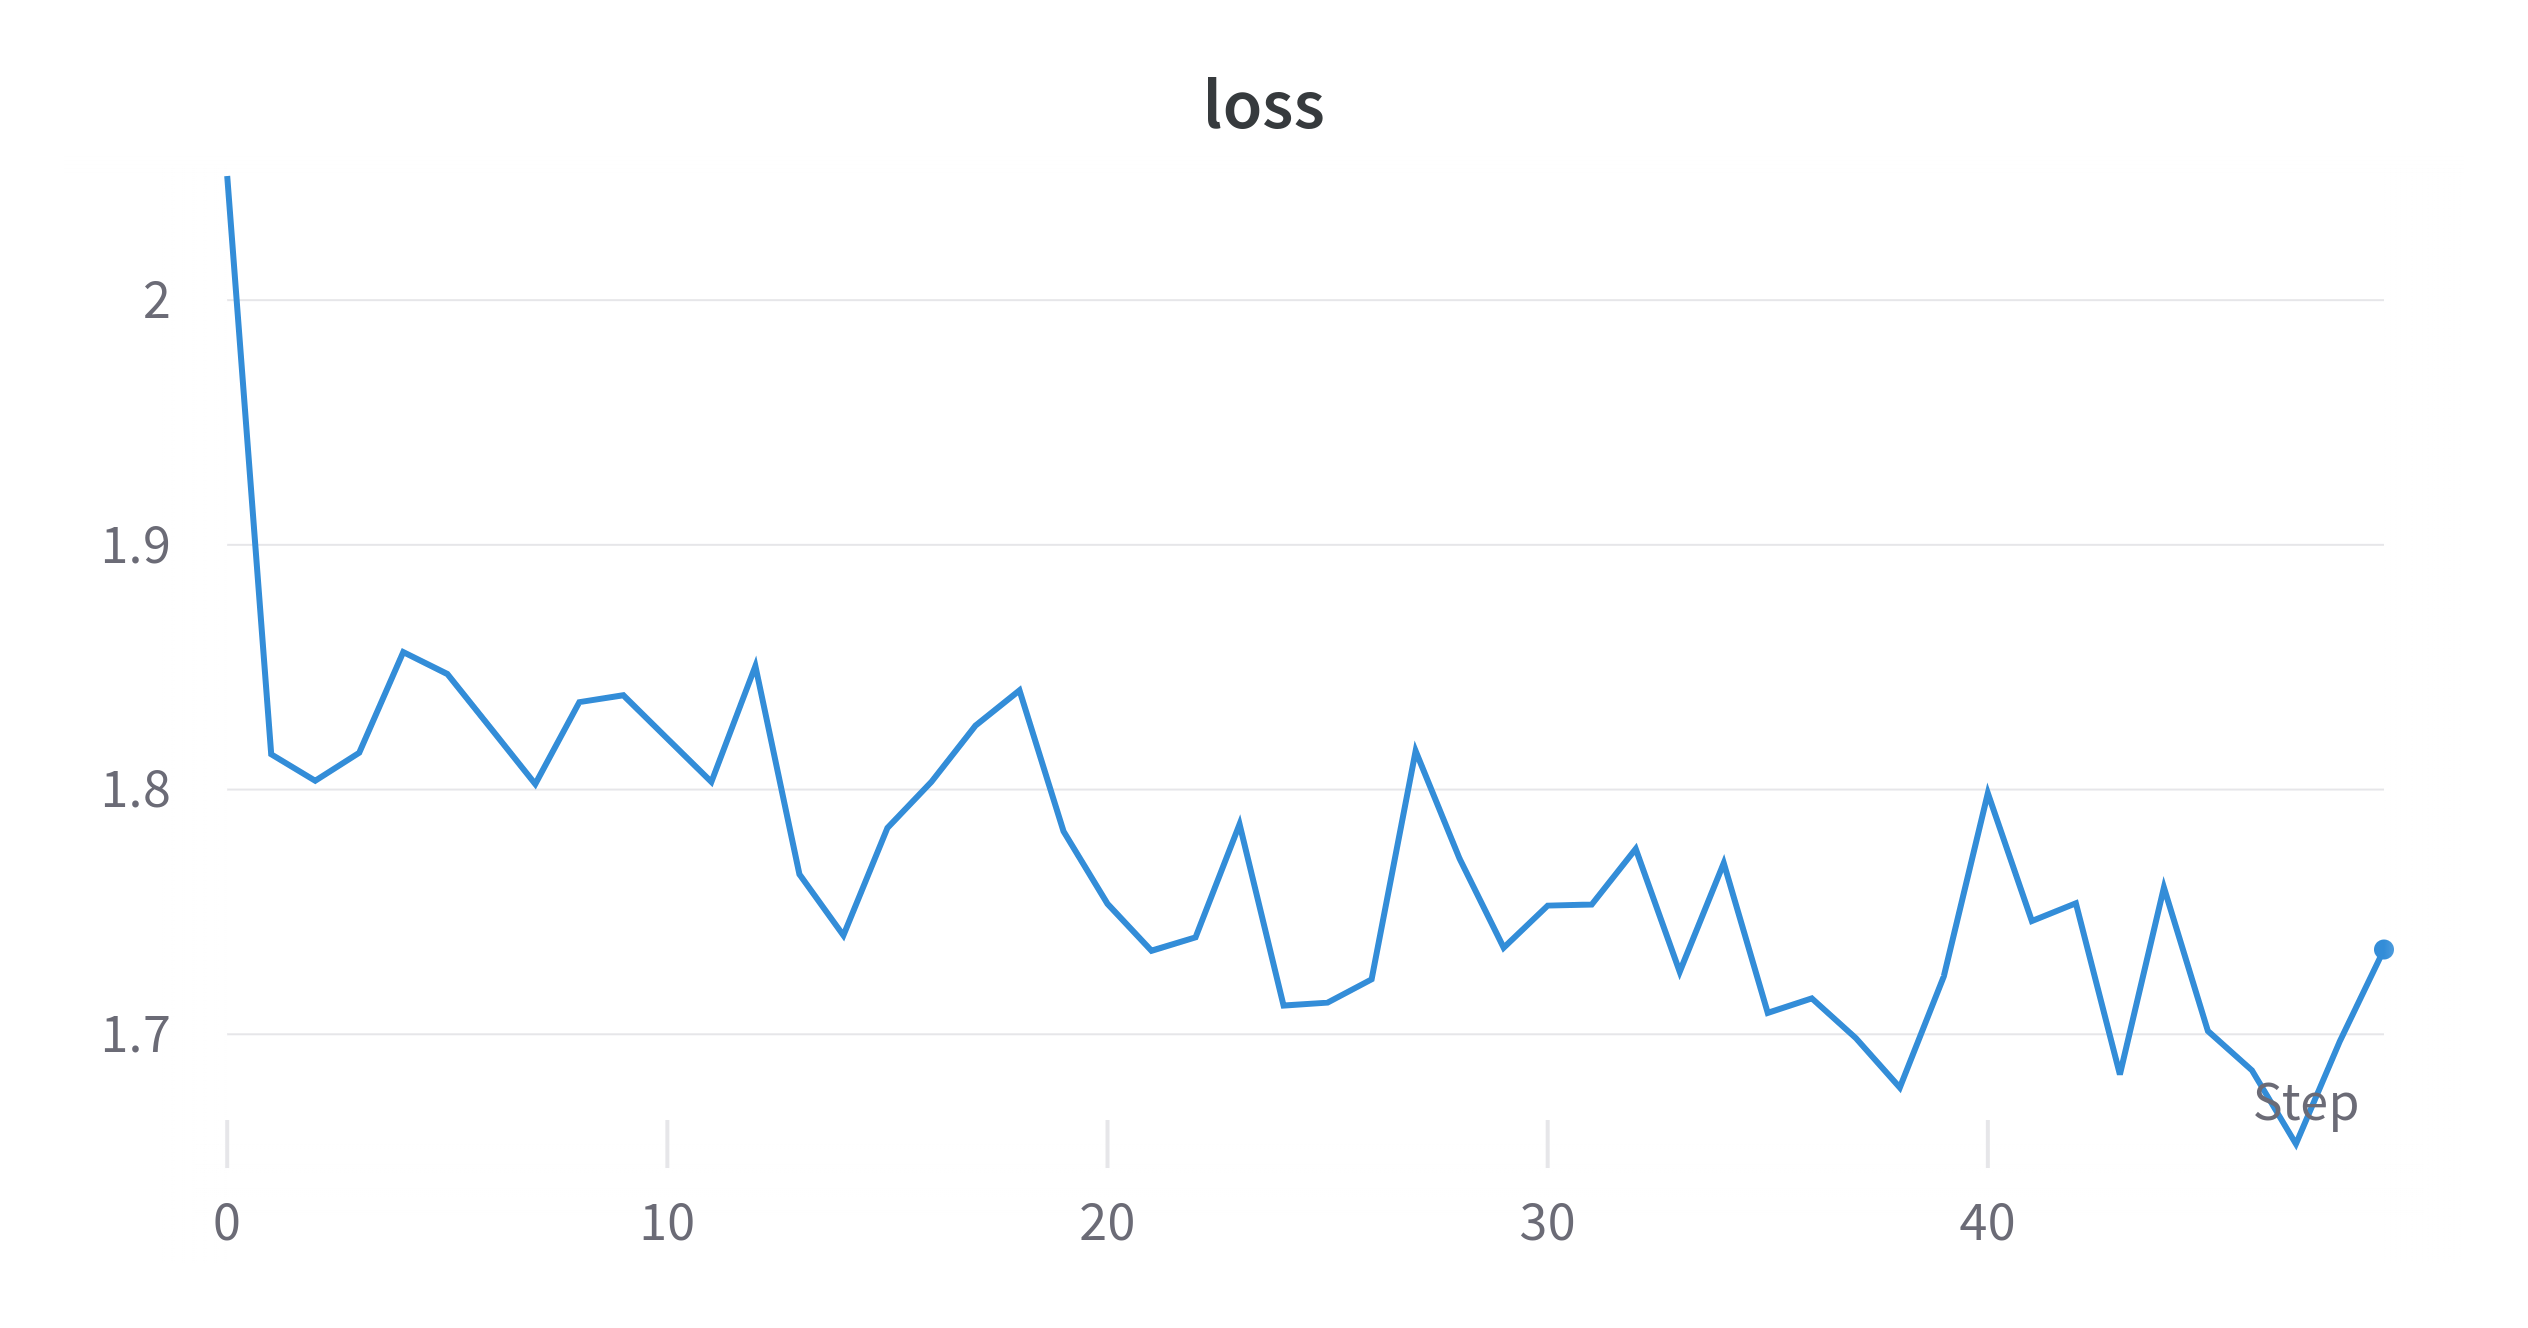

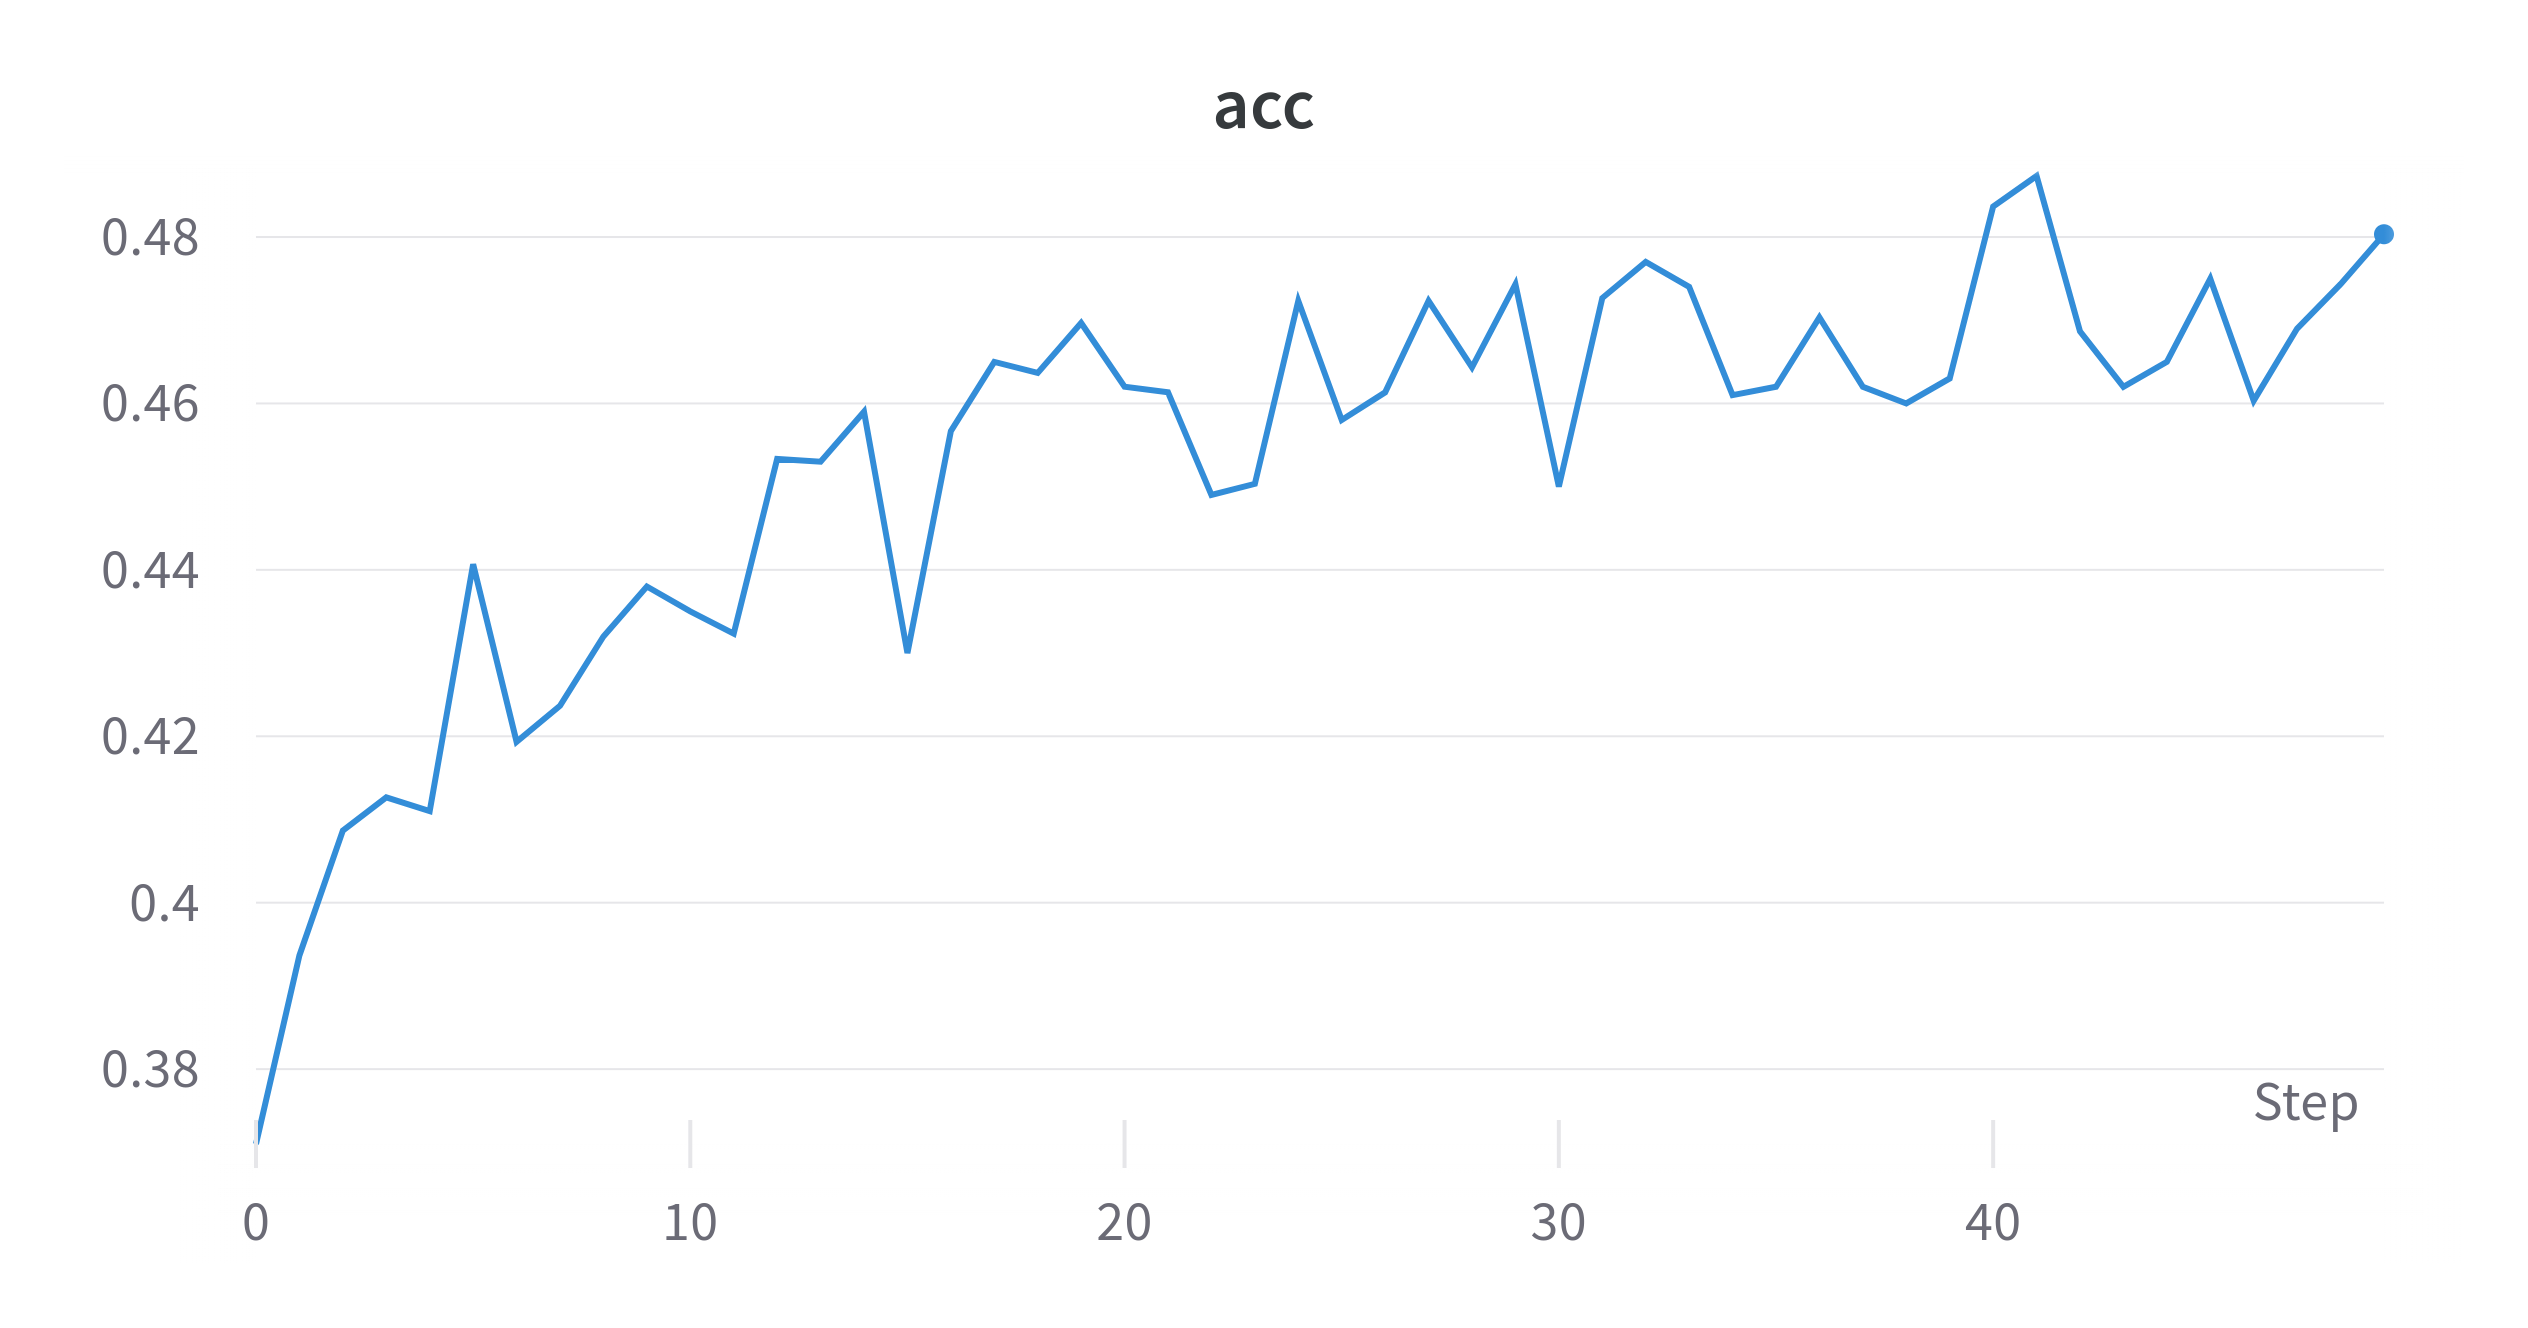

### Exercise 1.2: Rinse and Repeat

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Spoiler**: If you plan to do optional exercise 3.3, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).### Exercise 1.1: A baseline MLP

In [18]:

class down_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Convolution layer that does not reduce input size
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3), padding=1)
        # Polling layer for input size reduction
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)
    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = self.conv(x)
        x = F.relu(x)
        x = self.pool(x)
        x = F.relu(x)
        return x



class CNN(nn.Module):
    def __init__(self, num_channels, hidden_channels, num_layers):
        super().__init__()
        # Initial layers to reduce input size
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=hidden_channels, kernel_size=(3,3), stride=1),
            nn.MaxPool2d(3,stride=2, padding=1),
            #down_block(hidden_channels, hidden_channels),
        )
        # Single input size reduction block
        self.d = down_block(hidden_channels, hidden_channels)
        self.num_layers = num_layers
        # Size maintaining convolution
        self.conv = nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=(3,3), padding=1)
        # Classification Layer
        self.classify = nn.Linear(hidden_channels, 10)
        # Layer for feature extraction
        self.final_conv = nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=(2,2))
        # Global Average Pooling
        self.gap = torch.nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        x = self.layers(x)
        for _ in range(self.num_layers):
            x = F.relu(self.conv(x))
        x = F.relu(self.final_conv(x))
        x = self.gap(x)
        x = torch.flatten(x,start_dim=1)
        x = self.classify(x)
        return x

In [29]:
#Implementation of resnet18
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

class ResNet18(nn.Module):
    def __init__(self, in_channels, resblock, num_layers,outputs=10):
        super().__init__()
        self.num_layers = num_layers
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False)
        )

        self.loop_layer = resblock(128, 128, downsample = False)

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )


        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(512, outputs,bias=False)

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)

        for _ in range(self.num_layers):
            input = self.loop_layer(input)

        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        input = torch.flatten(input, start_dim=1)
        input = self.fc(input)
        return input

-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit.

### Exercise 2.1: Explain why Residual Connections are so effective
Use your two models (with and without residual connections) you developed above to study and **quantify** why the residual versions of the networks learn more effectively.

**Hint**: A good starting point might be looking at the gradient magnitudes passing through the networks during backpropagation.

In [22]:
#Simple CNN
config = {
    "model" : "CNN",
    "epochs" : 30,
    "lr" : 0.001,
    "batch_size" : 128,
    "input_channels" : 3,
    "num_layers" : 1,
    "hidden_channels": 256,
    "device": 'cuda'
}
with wandb.init(project="CNN-DLA1", config=config):

    device = config['device']
    criterion = torch.nn.CrossEntropyLoss()
    model_cnn = CNN(num_channels = config['input_channels'], hidden_channels = config['hidden_channels'], num_layers = config['num_layers']).to(device)
    model_cnn = train(model_cnn, config['epochs'], config['lr'], config['batch_size'], criterion, device)

Training:: 100%|██████████| 30/30 [12:26<00:00, 24.88s/it, acc=0.805, loss=0.401]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83      1000
           1       0.88      0.91      0.90      1000
           2       0.68      0.78      0.73      1000
           3       0.71      0.64      0.68      1000
           4       0.84      0.75      0.79      1000
           5       0.74      0.76      0.75      1000
           6       0.81      0.88      0.84      1000
           7       0.86      0.81      0.84      1000
           8       0.86      0.91      0.89      1000
           9       0.92      0.85      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



acc,▁▂▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇██▇█████▇██
loss,█▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
acc,0.80467
loss,0.40149


In [25]:
#Simple CNN with 5 added layers
config = {
    "model" : "CNN",
    "epochs" : 30,
    "lr" : 0.001,
    "batch_size" : 128,
    "input_channels" : 3,
    "num_layers" : 10,
    "hidden_channels": 256,
    "device": 'cuda'
}
with wandb.init(project="CNN-DLA1", config=config):

    device = config['device']
    criterion = torch.nn.CrossEntropyLoss()
    model_cnn = CNN(num_channels = config['input_channels'], hidden_channels = config['hidden_channels'], num_layers = config['num_layers']).to(device)
    model_cnn = train(model_cnn, config['epochs'], config['lr'], config['batch_size'], criterion, device)

Training:: 100%|██████████| 30/30 [27:11<00:00, 54.38s/it, acc=0.785, loss=0.466]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      1000
           1       0.88      0.90      0.89      1000
           2       0.81      0.64      0.71      1000
           3       0.62      0.68      0.65      1000
           4       0.81      0.75      0.78      1000
           5       0.63      0.83      0.71      1000
           6       0.83      0.85      0.84      1000
           7       0.91      0.74      0.82      1000
           8       0.90      0.86      0.88      1000
           9       0.83      0.86      0.85      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



acc,▁▃▅▅▅▆▆▇▆▇▇▇▇▇▇▇▇█████▇███████
loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
acc,0.785
loss,0.46606


In [ ]:
#Resnet18 with 1 added layers
config = {
    "model" : "ResNet",
    "epochs" : 30,
    "lr" : 0.001,
    "batch_size" : 128,
    "input_channels" : 3,
    "num_layers" : 1,
    "hidden_channels": 256,
    "device": 'cuda'
}
with wandb.init(project="CNN-DLA1", config=config):

    device = config['device']
    criterion = torch.nn.CrossEntropyLoss()
    model_res = ResNet18(in_channels = config['input_channels'], resblock=ResBlock, num_layers = config['num_layers']).to(device)
    model_cnn = train(model_res, config['epochs'], config['lr'], config['batch_size'], criterion, device)


Training:: 100%|██████████| 30/30 [03:17<00:00,  6.57s/it, acc=0.803, loss=0.373]
                                                            

Accuracy report on TEST:
               precision    recall  f1-score   support

           0       0.84      0.83      0.84      1000
           1       0.93      0.90      0.91      1000
           2       0.78      0.79      0.78      1000
           3       0.74      0.59      0.65      1000
           4       0.78      0.84      0.80      1000
           5       0.68      0.83      0.74      1000
           6       0.85      0.89      0.87      1000
           7       0.94      0.80      0.86      1000
           8       0.85      0.93      0.89      1000
           9       0.91      0.87      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.82     10000
weighted avg       0.83      0.83      0.82     10000



acc,▁▂▃▄▅▅▆▆▆▆▆▇▇▇▇█▇██▇█▇████████
loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
acc,0.803
loss,0.37344


In [30]:
#Resnet18 with 10 added layers
config = {
    "model" : "ResNet",
    "epochs" : 30,
    "lr" : 0.001,
    "batch_size" : 128,
    "input_channels" : 3,
    "num_layers" : 10,
    "hidden_channels": 256,
    "device": 'cuda'
}
with wandb.init(project="CNN-DLA1", config=config):

    device = config['device']
    criterion = torch.nn.CrossEntropyLoss()
    model_res = ResNet18(in_channels = config['input_channels'], resblock=ResBlock, num_layers = config['num_layers']).to(device)
    model_cnn = train(model_res, config['epochs'], config['lr'], config['batch_size'],criterion, device)

Training:: 100%|██████████| 30/30 [16:43<00:00, 33.44s/it, acc=0.804, loss=0.379]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83      1000
           1       0.89      0.93      0.91      1000
           2       0.76      0.81      0.78      1000
           3       0.62      0.70      0.66      1000
           4       0.85      0.77      0.80      1000
           5       0.71      0.77      0.74      1000
           6       0.95      0.73      0.83      1000
           7       0.83      0.89      0.86      1000
           8       0.89      0.91      0.90      1000
           9       0.88      0.89      0.89      1000

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



acc,▁▂▄▄▅▆▆▆▆▆▆▆▇▅▇▇▇▇█▇▇▇▇█▅▇█▇██
loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁
acc,0.804
loss,0.3789


From the above runs we can see that the base cnn has an accuracy of 80% and adding 9 layers reduces the accuracy by 2%, meanwhile increasing the number of layers in a resnet improves the accuracy by more than 1%

### Exercise 2.2: Fully-convolutionalize a network.
Take one of your trained classifiers and **fully-convolutionalize** it. That is, turn it into a network that can predict classification outputs at *all* pixels in an input image. Can you turn this into a **detector** of handwritten digits? Give it a try.

**Hint 1**: Sometimes the process of fully-convolutionalization is called "network surgery".

**Hint 2**: To test your fully-convolutionalized networks you might want to write some functions to take random MNIST samples and embed them into a larger image (i.e. in a regular grid or at random positions).

In [ ]:
# Your code here.

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.2 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes.

In [34]:
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
import cv2
# Helper function to normalize image
def normalize_img(img):
    img = img - np.min(img)
    img = img / np.max(img)
    img = np.uint8(255 * img)
    return img

# Compute class activation maps
def get_cam(model, device, img):
    # Define feature node for the feature extractor
    return_nodes = {
        "final_conv" : "final_conv"
    }
    # Define a feature extractor that returns the outputs of the return node
    fe = create_feature_extractor(model, return_nodes=return_nodes)

    model.eval()
    img = img.to(device)
    img2 = normalize_img(img.clone().cpu().permute(1,2,0).numpy())
    up_height, up_width = img2.shape[:2]
    nc = 256
    ds = []
    # Get weights for dot product
    weights = model.state_dict()['classify.weight']
    weights = weights.cpu().numpy()
    # Get features before gap
    features = fe(img.unsqueeze(0))['final_conv'].detach().cpu().numpy()
    height,width = features.shape[2:]
    for i in range(10):
        # Compute activation map
        d = weights[i].dot(features.reshape(nc,height * width))
        # Compute activation
        d = d.reshape(height,width)
        d = normalize_img(d)
        ds.append(cv2.resize(d,(up_height,up_width)))
    y = torch.argmax(model(img.unsqueeze(0)))
    heatmap = cv2.applyColorMap(cv2.resize(ds[y],(up_width, up_height)), cv2.COLORMAP_JET)
    result = heatmap * 0.2 + img2 * 0.6
    return result, y

In [31]:
#Simple CNN
config = {
    "model" : "CNN",
    "epochs" : 30,
    "lr" : 0.001,
    "batch_size" : 128,
    "input_channels" : 3,
    "num_layers" : 1,
    "hidden_channels": 256,
    "device": 'cuda'
}

with wandb.init(project="ACTIVATION-DLA1", config=config):
    device = config['device']
    criterion = torch.nn.CrossEntropyLoss()
    model_cnn = CNN(num_channels = config['input_channels'], hidden_channels = config['hidden_channels'], num_layers = config['num_layers']).to(device)
    model_cnn = train(model_cnn, config['epochs'], config['lr'], config['batch_size'], criterion, device)


Training:: 100%|██████████| 30/30 [13:17<00:00, 26.60s/it, acc=0.816, loss=0.424]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0       0.74      0.89      0.81      1000
           1       0.90      0.89      0.89      1000
           2       0.67      0.76      0.71      1000
           3       0.71      0.62      0.66      1000
           4       0.73      0.82      0.77      1000
           5       0.80      0.69      0.74      1000
           6       0.86      0.83      0.85      1000
           7       0.91      0.76      0.83      1000
           8       0.92      0.85      0.88      1000
           9       0.84      0.91      0.88      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000



acc,▁▂▄▅▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇████▇██
loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
acc,0.81633
loss,0.42421


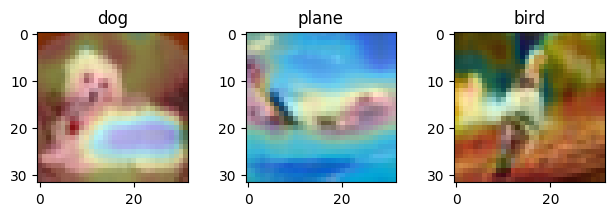

In [35]:
n = 3
sample = np.random.choice(range(len(ds_test)),size=n)
fig, axs = plt.subplots(1, n)
fig.tight_layout()
j = 0
for i in sample:
    cam, pred = get_cam(model_cnn, device, ds_test[i][0])

    cam = normalize_img(cam)
    # Set title red if the classification is wrong
    if ds_test[i][1] == pred.item():
        axs[j].set_title(classes[pred.item()])
    else:
        axs[j].set_title(classes[pred.item()],color='red')
    # Show activation map
    axs[j].imshow(cam)
    j += 1

We can see that the class activation maps work correctly, the dog is mainly identified by his face and interestingly even the background has a great impact on the recognition (maybe because dogs in photos are generally inside a house).
The plane is identified by his shape and color and the bird is again identified by the background